### Setup Env

In [ ]:
# Installing PyTorch
!pip install torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 621.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

In [ ]:
# temporary code for debugging

current_user = 'vicky'  # update the name to set corresponding file path

if current_user.lower() == 'vicky':
    # synthetic dataset
    train_img_path = '/content/drive/My Drive/datasets/VirtualKITTI/images5'
    train_label_path = '/content/drive/My Drive/datasets/VirtualKITTI/labels5'
    mapping_file_path_color = '/content/drive/My Drive/datasets/VirtualKITTI/0001_15-deg-left_scenegt_rgb_encoding.txt'

    val_img_path = '/content/drive/My Drive/datasets/VirtualKITTI/images_val'
    val_label_path = '/content/drive/My Drive/datasets/VirtualKITTI/labels_val'

    # real-world dataset
    test_img_path = '/content/drive/My Drive/datasets/Mapillary/validation_ds'

elif current_user.lower() == 'paulina':
    train_img_path = '/content/drive/My Drive/MADS/Computer Vision/VirtualKITTI/images100'
    train_label_path = '/content/drive/My Drive/MADS/Computer Vision/VirtualKITTI/labels100'
    mapping_file_path_color = '/content/drive/My Drive/MADS/Computer Vision/VirtualKITTI/0001_15-deg-left_scenegt_rgb_encoding.txt'

    real_img_path = '/content/drive/My Drive/MADS/Computer Vision/Mapillary/images5'
    val_img_path = '/content/drive/My Drive/MADS/Computer Vision/Mapillary/validation_ds'


### Define Dataset

Displaying original images to check path, and colors

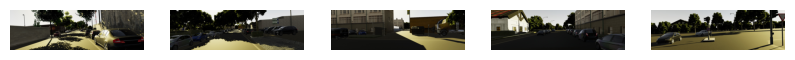

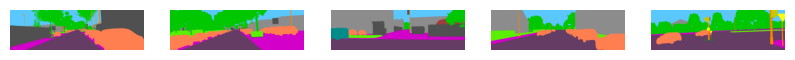

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os


def display_original_images(images_folder, num_images=5):
    """
    Display original images from the specified folder.
      :param images_folder: Path to the folder containing images.
      :param num_images: Number of images to display.
    """
    # Get all image paths from the specified folder
    image_paths = [os.path.join(images_folder, img) for img in os.listdir(images_folder)]

    # Display the first 'num_images' images
    plt.figure(figsize=(10, 10))
    for i, img_path in enumerate(image_paths[:num_images]):
        img = Image.open(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

display_original_images(train_img_path)
display_original_images(train_label_path)

Read color mapping file from synthetic dataset.

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor
import numpy as np

color_to_class_mapping = {}
# For mapping categories to unique integer IDs
category_to_id_mapping = {}
num_classes = 0

def read_color_to_class_mapping(file_path):
    next_id = 0

    with open(file_path, 'r') as f:
        next(f)
        for line in f:
            parts = line.strip().split()
            # The category is the first part
            category = parts[0]
            # The last three parts are RGB values
            r, g, b = map(int, parts[-3:])

            # Check if we have already assigned an ID to this category
            if category not in category_to_id_mapping:
                category_to_id_mapping[category] = next_id
                next_id += 1

            cat_id = category_to_id_mapping[category]
            color_to_class_mapping[(r, g, b)] = cat_id

    return color_to_class_mapping


def color_to_class(label_image, color_mapping):
    label_array = np.array(label_image)
    # Initialize witht the same height and width as label_image, but without color channel
    class_map = np.zeros(label_array.shape[:2], dtype=np.int64)

    for color, class_idx in color_mapping.items():
        matches = (label_array == color).all(axis=-1)
        class_map[matches] = class_idx

    # Holds classID for each pixel
    return torch.from_numpy(class_map)


Converting images to PyTorch tensors.

In [ ]:
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, ToTensor
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
import os
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, images_folder, labels_folder, transform=None, label_transform=None):
        self.images_folder = images_folder
        self.labels_folder = labels_folder
        self.color_to_class_mapping = read_color_to_class_mapping(mapping_file_path_color)
        self.transform = transform
        self.label_transform = label_transform
        self.images_paths = [os.path.join(images_folder, img) for img in os.listdir(images_folder)]
        self.labels_paths = [os.path.join(labels_folder, img.replace('rgb', 'classgt').replace('.jpg', '.png'))
                             for img in os.listdir(images_folder)]
        #self.labels_paths = [os.path.join(labels_folder, img.replace('.jpg', '.png')) for img in os.listdir(images_folder)]

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        img_path = self.images_paths[idx]
        image = Image.open(img_path)
        #image = Image.open(img_path).convert("RGB")

        label_path = self.labels_paths[idx]
        label_image = Image.open(label_path)

        # Resize label to match the model's output
        label = TF.resize(label_image, size=(256, 256), interpolation=Image.NEAREST)
        label = color_to_class(label, self.color_to_class_mapping)

        if self.transform is not None:
            image = self.transform(image)

        return image, label

transform = Compose([
    Resize((256, 256)),  # Resize images
    ToTensor(),
])

In [ ]:
train_dataset = CustomDataset(train_img_path, train_label_path, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

num_classes = max(category_to_id_mapping.values()) + 1
print("number of classes:", num_classes)


number of classes: 104


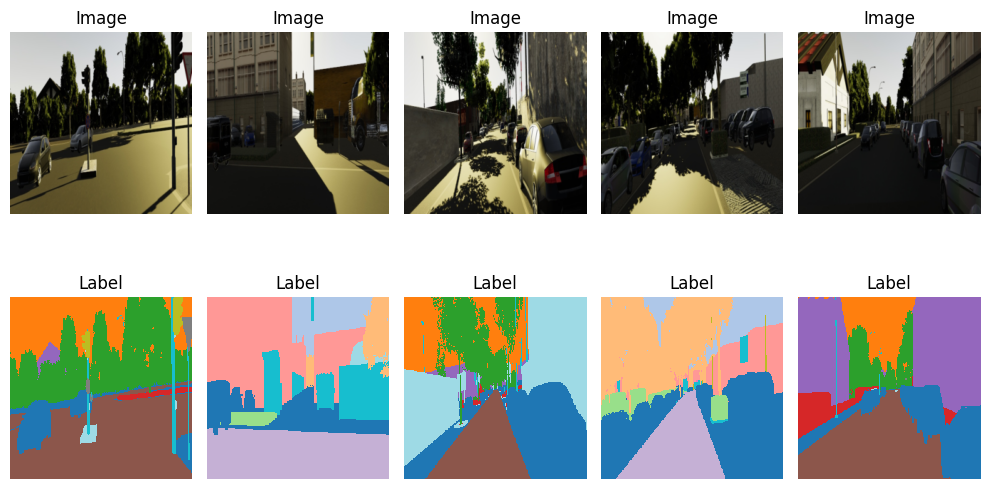

In [ ]:
import matplotlib.pyplot as plt
import torch

def showImg(ax, img_tensor):
    # Convert from PyTorch tensor to numpy array
    img = img_tensor.numpy().transpose((1, 2, 0))
    ax.imshow(img)
    ax.set_title("Image")
    ax.axis('off')

def showLabel(ax, label_tensor_or_array, cmap='tab20'):
    # Check if the input is a tensor
    if torch.is_tensor(label_tensor_or_array):
        label = label_tensor_or_array.numpy()
    else:
        label = label_tensor_or_array

    # Use the colormap for categorical data
    ax.imshow(label, cmap=cmap, interpolation='nearest')
    ax.set_title("Label")
    ax.axis('off')


dataiter = iter(train_dataloader)
images, labels = next(dataiter)

fig, axs = plt.subplots(2, 5, figsize=(10, 6))
for i in range(5):  # Show the first 5 images and labels
    showImg(axs[0, i], images[i])
    showLabel(axs[1, i], labels[i])

plt.tight_layout()
plt.show()


###Train Model

In [ ]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet101
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize and configure the model
# model = deeplabv3_resnet101(pretrained=True, num_classes=21)  # Adjust the number of classes
# Load the pretrained DeepLabV3 model
model = deeplabv3_resnet101(pretrained=True)
# Replace the Final Layer with number of classes from synthetic dataset
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1,1), stride=(1,1))
if 'aux_classifier' in model.__dict__['_modules']:
    model.aux_classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1,1), stride=(1,1))

model = model.to(device)

# Adjust hyper-parameters repetitively during training
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)


In [ ]:
num_epochs = 10  # Adjust as needed

train_loss_values = [] # Initialize a list to store the loss values

for epoch in range(num_epochs):
    model.train()
    epoch_losses = []  # List to store loss of each batch
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device, dtype=torch.long)
        # Check the shape of labels before squeezing
        # print(f"Labels shape before squeeze: {labels.shape}")

        # If necessary, remove the extra singleton dimension
        #if labels.dim() == 4 and labels.shape[1] == 1:
        #    labels = labels.squeeze(1)

        # Check the shape of labels after squeezing (if it was necessary)
        # print(f"Labels shape after squeeze: {labels.shape}")

        optimizer.zero_grad()
        output = model(images)['out']
        loss = F.cross_entropy(output, labels)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    average_loss = sum(epoch_losses) / len(epoch_losses)
    train_loss_values.append(average_loss)

    # print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    print(f"Epoch {epoch+1}, Training Loss: {average_loss}")


Epoch 1, Training Loss: 4.681940078735352
Epoch 2, Training Loss: 4.167038917541504
Epoch 3, Training Loss: 3.5092930793762207
Epoch 4, Training Loss: 2.7960286140441895
Epoch 5, Training Loss: 2.1377480030059814
Epoch 6, Training Loss: 1.618756651878357
Epoch 7, Training Loss: 1.2561167478561401
Epoch 8, Training Loss: 1.0140669345855713
Epoch 9, Training Loss: 0.8464047312736511
Epoch 10, Training Loss: 0.7344173192977905


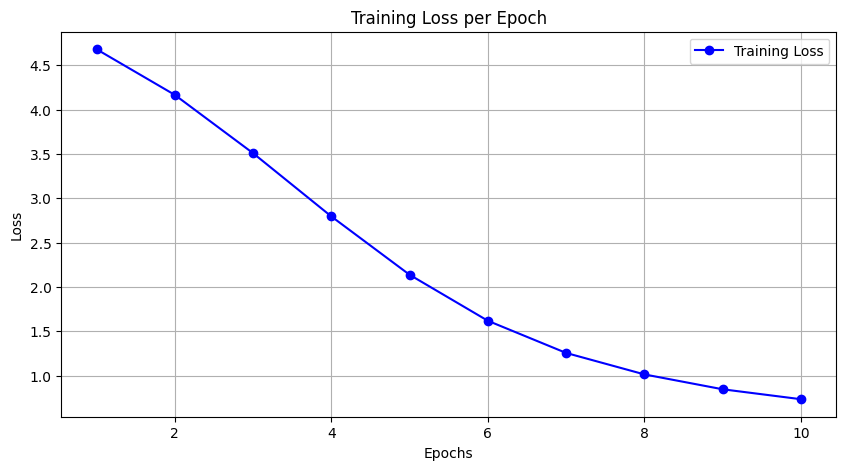

In [ ]:
import matplotlib.pyplot as plt

# Plotting the epochs and corresponding loss values
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_loss_values, 'bo-', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()


-------------------------------------

###Validation

In [ ]:
val_dataset = CustomDataset(val_img_path, val_label_path, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [ ]:
# Helper function to calculate pixel accuracy
def calculate_pixel_accuracy(preds, labels):
    correct = torch.eq(preds, labels).sum().item()
    total = torch.numel(labels)
    return correct / total

# Helper function to calculate IoU for a single class
def calculate_iou(preds, labels, class_id):
    intersection = ((preds == class_id) & (labels == class_id)).sum().item()
    union = ((preds == class_id) | (labels == class_id)).sum().item()
    if union == 0:
        return float('nan')  # Avoid division by zero
    else:
        return intersection / union


In [ ]:
# Initialize accumulators
pixel_accuracies = []
ious = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)['out']
        # Get the predicted labels
        predictions = torch.argmax(outputs, dim=1)

        # Calculate metrics
        pixel_accuracy = calculate_pixel_accuracy(predictions, labels)
        pixel_accuracies.append(pixel_accuracy)

        # Calculate IoU for each class and average
        iou_per_class = [calculate_iou(predictions, labels, class_id) for class_id in range(num_classes)]
        ious.append(iou_per_class)

# Calculate mean pixel accuracy across all images
mean_pixel_accuracy = sum(pixel_accuracies) / len(pixel_accuracies)

# Calculate mean IoU per class across all images
mean_ious = np.nanmean(ious, axis=0)
mean_iou = np.nanmean(mean_ious)

print(f"Mean Pixel Accuracy: {mean_pixel_accuracy}")
print(f"Mean IoU: {mean_iou}")


Mean Pixel Accuracy: 0.44239501953125
Mean IoU: 0.029042407514660206


<ipython-input-92-c450ee95684a>:25: RuntimeWarning: Mean of empty slice
  mean_ious = np.nanmean(ious, axis=0)


In [ ]:
val_loss_values = []  # Initialize a list to store the evaluation loss values

for epoch in range(num_epochs):
    model.eval()
    epoch_losses = []  # List to store loss of each batch in evaluation
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.long)

            output = model(images)['out']
            loss = F.cross_entropy(output, labels)

            epoch_losses.append(loss.item())

    average_loss = sum(epoch_losses) / len(epoch_losses)
    val_loss_values.append(average_loss)

    print(f"Epoch {epoch+1}, Validation Loss: {average_loss}")


Epoch 1, Validation Loss: 2.285001039505005
Epoch 2, Validation Loss: 2.285000801086426
Epoch 3, Validation Loss: 2.285000801086426
Epoch 4, Validation Loss: 2.2850005626678467
Epoch 5, Validation Loss: 2.285001039505005
Epoch 6, Validation Loss: 2.2850005626678467
Epoch 7, Validation Loss: 2.2850005626678467
Epoch 8, Validation Loss: 2.285000801086426
Epoch 9, Validation Loss: 2.285000801086426
Epoch 10, Validation Loss: 2.285001039505005


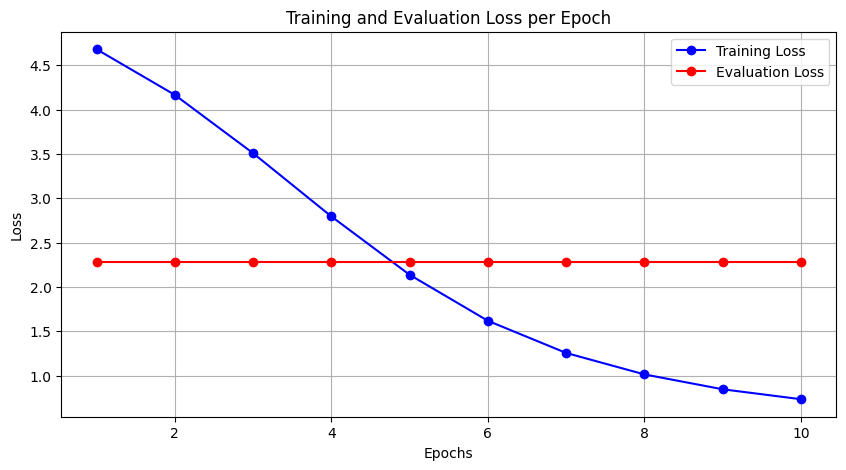

In [ ]:
plt.figure(figsize=(10, 5))

assert len(train_loss_values) == len(val_loss_values), "The length of training and evaluation losses must be the same."

# Plot training and evaluation losses
plt.plot(range(1, num_epochs + 1), train_loss_values, 'bo-', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_values, 'ro-', label='Evaluation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()


###Prediction

Apply trained semantic segmentation model to real-world images to generate pseudo-labels.

In [ ]:
class RealDataset(Dataset):
    def __init__(self, images_folder, transform=None):
        self.images_folder = images_folder
        self.transform = transform
        # Include only files with specific image extensions
        valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
        self.images_paths = [os.path.join(images_folder, img) for img in os.listdir(images_folder)]
        # If no transform is passed, use a default transform
        if transform is None:
            self.transform = Compose([
                Resize((256, 256)),
                ToTensor(),
            ])
        else:
            self.transform = transform


    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        img_path = self.images_paths[idx]
        # image = Image.open(img_path).convert('RGB')
        image = Image.open(img_path)
        image = self.transform(image)
        print(image.size())
        return image


In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Define the transformation
transform = Compose([
    Resize((256, 256)),  # Resize the image to 256x256 pixels
    ToTensor(),  # Convert the image to a PyTorch tensor
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet's mean and std
])

In [ ]:
test_dataset = RealDataset(test_img_path, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# Reverse mapping from class IDs back to colors
def create_reverse_mapping(color_to_class_mapping):
    class_to_color_mapping = {class_id: color for color, class_id in color_to_class_mapping.items()}
    return class_to_color_mapping

# Save the reverse mapping for later use
color_to_class_mapping = read_color_to_class_mapping(mapping_file_path_color)
class_to_color_mapping = create_reverse_mapping(color_to_class_mapping)

def class_to_color(prediction, class_to_color_mapping):
    # Convert class IDs to color image
    color_image = np.zeros((*prediction.shape, 3), dtype=np.uint8)

    for class_id, color in class_to_color_mapping.items():
        color_image[prediction == class_id] = color

    return color_image

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction(image, prediction, class_to_color_mapping):
    # Convert the prediction to a color image using the reverse mapping
    color_pred_image = class_to_color(prediction, class_to_color_mapping)

    # Assuming image and prediction are CPU tensors
    # image = image.permute(1, 2, 0).numpy()
    img = image.transpose((1, 2, 0))

    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(color_pred_image)
    # plt.imshow(color_pred_image, cmap='tab20', interpolation='nearest')
    plt.title('Model Prediction')
    plt.axis('off')

    plt.show()


Prediction for the real-world dataset

In [ ]:
test_dataset = RealDataset(test_img_path, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


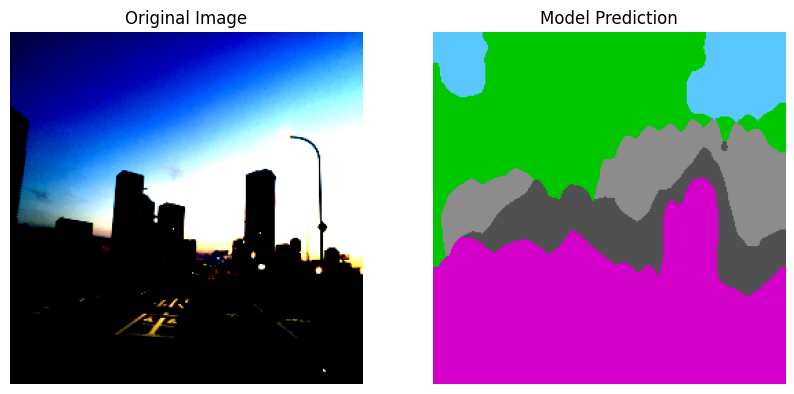

In [ ]:
# Fetch an image from the eval_dataloader and visualize prediction
images = next(iter(test_dataloader))
images = images.to(device)

model.eval()
with torch.no_grad():
    for images in test_dataloader:
        images = images.to(device)

        outputs = model(images)['out']
        # softmax = torch.nn.functional.softmax(outputs, dim=1)  # Assuming 'out' is a 4D tensor [N, C, H, W]
        # predictions = torch.argmax(softmax, dim=1)  # Get the predicted labels
        predictions = torch.argmax(outputs, dim=1)

        if len(predictions.shape) == 3:
            visualize_prediction(images[0].cpu().numpy(), predictions[0].cpu().numpy(), class_to_color_mapping)
        else:
            print("Unexpected prediction shape:", predictions.shape)

        break  # Just visualize the first batch
